In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

# Read in Small Data (metadata)

In [174]:
metadata = pd.read_csv('big_data/metadata.csv')
metadata = metadata[pd.isnull(metadata['abstract']) == False].reset_index(drop=True)

In [175]:
count = sum(metadata['abstract'].str.contains('COVID'))
print('There are ' + str(count) + ' articles mentioning COVID, which likely refers to COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19'))
print('There are ' + str(count) + ' articles mentioning COVID-19.')

count = sum(metadata['abstract'].str.contains('COVID-19')[(pd.isnull(metadata['abstract']) == False) & 
                                                          (metadata['abstract'].str.contains('COVID-19'))
                                                         ] 
           )
print('There are ' + str(count) + ' articles mentioning COVID and COVID-19.')

There are 905 articles mentioning COVID, which likely refers to COVID-19.
There are 881 articles mentioning COVID-19.
There are 881 articles mentioning COVID and COVID-19.


In [176]:
covid_article_indexes = np.argwhere(metadata['abstract'].str.contains('COVID')).T[0]

C:\Users\vldoa\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:56: FutureWarning: Series.nonzero() is deprecated and will be removed in a future version.Use Series.to_numpy().nonzero() instead
  bound = getattr(obj, method, None)


# SciBERT Implementation

In [177]:
# from transformers import *

# tokenizer = AutoTokenizer.from_pretrained('big_data/allenai/scibert_scivocab_uncased')
# model = AutoModel.from_pretrained('big_data/allenai/scibert_scivocab_uncased')

# Traditional ML

## Preprocessing

In [178]:
# metadata['abstract_processed'] = metadata['abstract'].str.lower()
# metadata["abstract_processed"] = metadata['abstract_processed'].str.replace('[^\w\s]','')

In [179]:
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
# nltk.download('wordnet')
from nltk.corpus import wordnet

stemmer = SnowballStemmer('english')

In [180]:
# function to perform lemmatize and stem preprocessing steps on the data set.

def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))
    return result

In [181]:
t = time.time()
metadata['gensim_abstract_processed'] = metadata['abstract'].map(preprocess)
print(time.time() - t)

191.2261552810669


Remove additional stop words

In [182]:
stop = ['abstract']
metadata['gensim_abstract_processed'] = metadata['gensim_abstract_processed'].apply(
    lambda x: [item for item in x if item not in stop])

Create a dictionary for word counts

In [183]:
dictionary = gensim.corpora.Dictionary(metadata['gensim_abstract_processed'])
count = 0
for k, v in dictionary.iteritems():
    print(k, v)
    count += 1
    if count > 10:
        break
print(str(len(dictionary)) + ' unique words')

0 abnorm
1 addit
2 agent
3 allow
4 anim
5 antivir
6 appear
7 area
8 associ
9 basi
10 birth
55192 unique words


In [184]:
# Select which words in the dict to keep
dictionary.filter_extremes(no_below=2,
                           #no_above=0.5, 
                           #keep_n=100000
                          )
print(str(len(dictionary)) + ' unique words')

25794 unique words


In [185]:
# Create corpus
bow_corpus = [dictionary.doc2bow(doc) for doc in metadata['gensim_abstract_processed']]

# Preview the corpus
bow_doc_4310 = bow_corpus[100]
for i in range(len(bow_doc_4310)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_4310[i][0], 
                                               dictionary[bow_doc_4310[i][0]], 
bow_doc_4310[i][1]))

Word 16 ("cell") appears 2 time.
Word 61 ("major") appears 1 time.
Word 228 ("rhinovirus") appears 1 time.
Word 229 ("serotyp") appears 1 time.
Word 240 ("unit") appears 1 time.
Word 446 ("resolut") appears 1 time.
Word 517 ("human") appears 1 time.
Word 533 ("termin") appears 1 time.
Word 553 ("molecul") appears 2 time.
Word 587 ("probabl") appears 1 time.
Word 686 ("group") appears 2 time.
Word 1086 ("intercellular") appears 1 time.
Word 1109 ("space") appears 1 time.
Word 1169 ("domain") appears 1 time.
Word 1195 ("receptor") appears 1 time.
Word 2046 ("adhes") appears 1 time.
Word 2047 ("crystal") appears 2 time.
Word 2048 ("diffract") appears 1 time.
Word 2049 ("dimens") appears 1 time.
Word 2050 ("trigon") appears 1 time.


In [186]:
# Creating tf-idf matrix from bow (not clear if needed)

from gensim import corpora, models
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break

[(0, 0.057132458636599624),
 (1, 0.025289935059486072),
 (2, 0.06406245672763695),
 (3, 0.03777505840690098),
 (4, 0.02891652922384414),
 (5, 0.031724717871507484),
 (6, 0.03869818383959291),
 (7, 0.037986946374660956),
 (8, 0.06116698934085502),
 (9, 0.046571462910656274),
 (10, 0.062236120171326625),
 (11, 0.044473855799772026),
 (12, 0.06940385977583172),
 (13, 0.06736539666029824),
 (14, 0.02522041798279582),
 (15, 0.0533714961901252),
 (16, 0.044669666994347074),
 (17, 0.04965747190862404),
 (18, 0.0765167769266904),
 (19, 0.06919890462220024),
 (20, 0.02241579825103641),
 (21, 0.5916613179855027),
 (22, 0.036517877495472854),
 (23, 0.022069462328089564),
 (24, 0.09209044548272646),
 (25, 0.028968959032340005),
 (26, 0.09821638133561973),
 (27, 0.03557295164530385),
 (28, 0.15901727287138065),
 (29, 0.03105123241473796),
 (30, 0.06591235707237193),
 (31, 0.06985989373798382),
 (32, 0.08494902996098504),
 (33, 0.07415307506918753),
 (34, 0.03345697283048187),
 (35, 0.03694682516024

## PCA

## Implementation

In [187]:
# .T to transpose since it's a word-doc matrix, not doc-word matrix
tfidf_sparse = gensim.matutils.corpus2csc(corpus_tfidf, printprogress=500).T

In [188]:
from sklearn.preprocessing import normalize
tfidf_sparse_norm = normalize(tfidf_sparse, norm='l1', axis=1)

(0, 1.01)

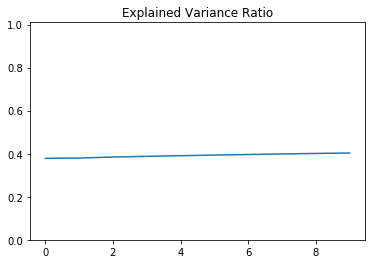

In [189]:
truncatedsvd = TruncatedSVD(n_components = 30, algorithm = 'randomized', random_state = 20)

transformed = truncatedsvd.fit_transform(tfidf_sparse_norm)

plt.title('Explained Variance Ratio')
plt.plot(np.cumsum(truncatedsvd.explained_variance_ratio_)[0:10])
plt.ylim(0, 1.01)

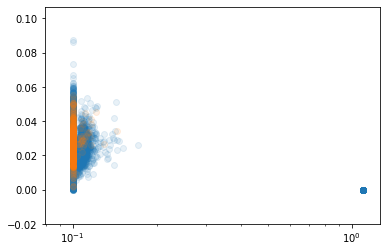

In [190]:
xscale_log_addition = 0.1

not_covid = (np.isin(np.array(list(range(len(transformed)))), covid_article_indexes) == False)
plt.scatter(transformed[not_covid,0] + xscale_log_addition,
            transformed[not_covid,1], alpha=0.1)

plt.scatter(transformed[covid_article_indexes,0] + xscale_log_addition,
            transformed[covid_article_indexes,1], alpha=0.1)
# plt.yscale('log')
plt.xscale('log')

## Analysis

In [201]:
word_ids_sorted = np.argsort(np.abs(truncatedsvd.components_[0]))[::-1]
[(dictionary[word_ids_sorted[i]], truncatedsvd.components_[0, word_ids_sorted[i]]) for i in range(100)]

[('unknown', 0.9999998590864289),
 ('sar', 9.564383939883364e-05),
 ('virus', 8.705889741094843e-05),
 ('protein', 7.751716340018182e-05),
 ('cell', 7.479889863047164e-05),
 ('infect', 7.168677154854787e-05),
 ('coronavirus', 6.759051352990616e-05),
 ('patient', 6.578549514712586e-05),
 ('viral', 6.165543339278458e-05),
 ('sequenc', 6.137787216261877e-05),
 ('human', 6.111701867293777e-05),
 ('outbreak', 5.5175754861927814e-05),
 ('diseas', 5.495407507268519e-05),
 ('respiratori', 5.344427484550256e-05),
 ('etiolog', 5.333025284749956e-05),
 ('replic', 5.0146661743935145e-05),
 ('caus', 4.937873580082705e-05),
 ('case', 4.912768694654542e-05),
 ('genom', 4.718719583121541e-05),
 ('pneumonia', 4.7117383440803634e-05),
 ('identifi', 4.59243444905858e-05),
 ('detect', 4.5397415403699e-05),
 ('express', 4.488824922399317e-05),
 ('pathogen', 4.361672626152448e-05),
 ('respons', 4.2740169727610975e-05),
 ('report', 4.24582001686532e-05),
 ('host', 4.22504705841878e-05),
 ('china', 4.21798605

In [217]:
metadata['component_0'] = transformed[:,0] * 10**6
metadata['component_1'] = transformed[:,1] * 10**6

metadata['component_0_percentile'] = metadata['component_0'].rank(pct=True)
metadata['component_1_percentile'] = metadata['component_1'].rank(pct=True)

In [220]:
metadata['abstract_COVID'] = metadata['abstract'].str.contains('COVID')

In [223]:
metadata.columns

Index(['sha', 'source_x', 'title', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal',
       'Microsoft Academic Paper ID', 'WHO #Covidence', 'has_full_text',
       'full_text_file', 'gensim_abstract_processed', 'component_0',
       'component_1', 'component_0_percentile', 'component_1_percentile',
       'abstract_COVID'],
      dtype='object')

In [226]:
metadata_small = metadata[[
    'title', 'doi', 'pmcid', 'pubmed_id', 'abstract', 'publish_time', 'journal', 
    
    'component_0', 'component_1', 'component_0_percentile', 'component_1_percentile', 'abstract_COVID'
]]
metadata_small.to_csv('big_data/metadata_PCAed.csv', sep='|')